In [7]:
import sys,os,glob,copy
sys.path.append('../')
import numpy as np
from numpy.linalg import norm
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.interpolate import LinearNDInterpolator,interp2d
import matplotlib as mpl
from matplotlib.colors import LogNorm
from IPython.display import display, Markdown
import glob
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution


#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.cm.get_cmap('RdYlBu')


pd.set_option('display.max_rows', 200)

### Load CMS data

In [8]:
cmsData = pd.read_pickle('../AuxInfo/CMS-EXO-20-004-data/ADD_Monojet_DF.pcl')
cmsData['filename'] = 'CMS'

### Load Recast data

In [14]:
files = {'all' : '../add_11_3_cms_exo_20_004.pcl'}


allData = cmsData
for label,f in files.items():
    recastData = pd.read_pickle(f)
    recastData['filename'] = label
    recastData['$M_{D}$'] = 11
    recastData['$d$'] = 3
    allData = pd.concat((allData,recastData))
    
allData.sort_values(['Coupling','Mode','$M_{D}$','$d$','Data-takingperiod'],inplace=True,
              ascending=[False,False,True,True,False])    

### Load MA5 data

In [15]:
ma5file = '../MadAnalysis5/bin/ANALYSIS_0/summary.pcl'
ma5Data = pd.read_pickle(ma5file)
ma5Data['filename'] = 'MA5'

In [16]:
modelData = recastData[['$M_{D}$','$d$','Data-takingperiod']]
dfModel = allData.merge(modelData,how='right')

### Get MET bins

In [17]:
bins = {c : eval(c.split('_')[1]) for c in dfModel.columns if ("bin_" in c and not 'Error' in c)}
binsError = {c : eval(c.split('_')[1]) for c in dfModel.columns if ("bin_" in c and 'ErrorPlus' in c)}
data = {}
dataError = {}
for fname in dfModel['filename']:
    data[os.path.basename(fname)] = {c : dfModel[dfModel['filename'] == fname][c].iloc[0] 
                                     for c in bins}
    dataError[os.path.basename(fname)] = {c : dfModel[dfModel['filename'] == fname][c].iloc[0] 
                                         for c in binsError}
    
rightBin = 2000.
binCenter = (np.array(list(bins.values()))+np.diff(list(bins.values())+[rightBin])/2).tolist()    
binLeft = [bins[c] for c in bins]+[rightBin]

### Get MA5 MET bins

In [19]:
weightsMA5 = {c : 0. for c in bins}
weightsErrorMA5 = {c : 0. for c in binsError}
dataPeriod = dfModel['Data-takingperiod'].iloc[0]
lumi = dfModel['Luminosity (1/fb)'].iloc[-1]
# nevts = ma5Data['Total MC Events'].iloc[0]
nevts = 50000
# The MA5 efficiencies include the splitting into 3 distinct data periods
# so we must rescale them by this fraction:
effFix = 137./lumi 
for irow,row in ma5Data.iterrows():
    if not str(dataPeriod) in row['signal region']:
        continue
    ibin = eval(row['signal region'].split('_bin')[1])
    binLabel = 'bin_%1.1f_%1.1f' %(binLeft[ibin],binLeft[ibin+1])
    binErrorLabel = binLabel+'_ErrorPlus'
    eff = row['efficiency']*effFix
#     xsec = row['Total xsec (pb)']
    xsec = 0.03
    weightsMA5[binLabel] = eff*xsec*lumi*1e3
    if eff != 0.:
        weightsErrorMA5[binErrorLabel] = weightsMA5[binLabel]/np.sqrt(eff*nevts)
    
data['MA5'] = weightsMA5
dataError['MA5'] = weightsErrorMA5

### Plot MET bins

/tmp/ipykernel_25752/3862022494.py:29: RuntimeWarning: divide by zero encountered in divide
  relDiffErr = np.abs(weights-weightsCMS)/error


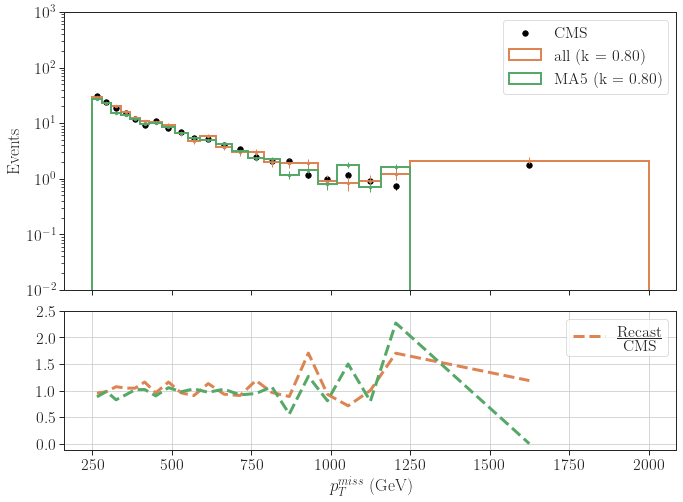

In [22]:
kfactors = {'all' : 0.8, 'MA5' : 0.8}

f, axarr = plt.subplots(2,sharex=True, gridspec_kw = {'height_ratios':[2, 1]},figsize=(10,8))
plt.subplots_adjust(left=0.12, bottom=0.12, right=0.97, top=None, wspace=None, hspace=0.1)
colors = {label : sns.color_palette('deep')[i] for i,label in enumerate(data.keys())}    
colors['CMS'] = 'black'
weightsCMS = np.array([data['CMS'][c] for c in bins])

first = True
for label in data:    
    if label in kfactors:
        kfactor = kfactors[label]
    else:
        kfactor = 1.0
    weights = kfactor*np.array([data[label][c] for c in bins])
    error = kfactor*np.array([dataError[label][c] for c in binsError])    
    if label == 'CMS':        
        axarr[0].scatter(x=binCenter,y=weights,s=30,c=colors[label],label=label)
    else:
        axarr[0].hist(binCenter,bins=binLeft,
                       label=label+' (k = %1.2f)' %kfactor,linewidth=2,
                       weights=weights,histtype='step',
                      color=colors[label])
        
        
        
        relDiff = (weights-weightsCMS)/weightsCMS
        ratio = weights/weightsCMS
        relDiffErr = np.abs(weights-weightsCMS)/error
        #Plot ratio
        if first:
            label1 = r'$\frac{\mbox{(CMS-Recast)}}{\mbox{MC Error}}$'
            label2 = r'$\frac{\mbox{Recast}}{\mbox{CMS}}$'
            first = False
        else:
            label1 = None
            label2 = None
#         axarr[1].plot(binCenter,relDiffErr,linewidth=3.0,color=colors[label],
#                       label=label1,alpha=0.5)
        axarr[1].plot(binCenter,ratio,linewidth=3.0,color=colors[label],linestyle='--', 
                      label=label2)        

    axarr[0].errorbar(binCenter,weights,yerr = error, marker = '.', elinewidth=1.0,
             drawstyle = 'steps-mid',linewidth=0.0,color=colors[label])
    
    
axarr[1].set_yticks([0.,0.5,1.0,1.5,2.0,2.5])
axarr[1].grid(True)
axarr[1].set_xlabel(r'$p_{T}^{miss}$ (GeV)')
axarr[0].set_yscale('log')
axarr[0].set_ylabel('Events')
axarr[0].legend()
axarr[1].legend()
axarr[0].set_ylim(1e-2,1e3)
# axarr[0].set_title('k-factor = %1.2f' %kfactor)
plt.show()
